**CSI 5138 Homework 3**

Use Vanilla RNN and LSTM to for text classification and sentiment analysis on a standard dataset of movie reviews.

# Setup

In [128]:
#from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import gensim

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, Dense, Flatten
from keras.layers import Input, LSTM, Dropout, SimpleRNN
from keras.models import Sequential, Model
from keras import optimizers

import matplotlib
import matplotlib.pyplot as plt

import os
import numpy as np

from pprint import pprint

# IMDB Movie Review Dataset, Test and Training Data

In [2]:
def processReviews(paths):
    texts = []
    ratings = []
    
    for path in paths:
        for file in os.listdir(path):
            # get review
            rating = file.split('_')[1]
            rating = rating.split('.')[0]
            file = os.path.join(path, file)
            with open(file, "r", encoding='utf-8') as f:
                text = []
                for line in f:
                    # do some pre-processing and combine list of words for each review text             
                    text += gensim.utils.simple_preprocess(line)
                texts.append(text)
                ratings.append(rating)
        
    return [texts, ratings]

In [3]:
Xtrain, ytrain = processReviews(["./aclImdb/train/neg/", "./aclImdb/train/pos/"])
Xtest, ytest = processReviews(["./aclImdb/test/neg/", "./aclImdb/test/pos/"])

In [122]:
# save to file
with open('gensim', 'w', encoding="utf-8") as fout:
    pprint([Xtrain, ytrain, Xtest, ytest], fout)

In [123]:
# read from file
with open('gensim', 'r', encoding="utf-8") as fin:
    content = eval(fin.read())

Xtrain, ytrain, Xtest, ytest = content

In [124]:
print(Xtrain[0][:5])
print(ytrain[0])
print(Xtest[0][:5])
print(ytest[0])
print(Xtrain[12500][:5])
print(ytrain[12500])
print(Xtest[12500][:5])
print(ytest[12500])
print("# Xtrain: ", len(Xtrain))
print("# ytrain: ", len(ytrain))
print("# Xtest: ", len(Xtest))
print("# ytest: ", len(ytest))

['story', 'of', 'man', 'who', 'has']
3
['once', 'again', 'mr', 'costner', 'has']
2
['bromwell', 'high', 'is', 'cartoon', 'comedy']
9
['went', 'and', 'saw', 'this', 'movie']
10
# Xtrain:  25000
# ytrain:  25000
# Xtest:  25000
# ytest:  25000


In [60]:
X = list(Xtrain + Xtest)
y = list(ytrain + ytest)
print("# X: ", len(X))
print("# y: ", len(y))

# X:  50000
# y:  50000


In [67]:
# convert reviews to pos and negative
# pos 1, neg 0
print(y[:10])
print(y[-10:])
y = [int(a)>= 7 for a in y]
print(y[:10])
print(y[-10:])

['3', '4', '4', '1', '1', '3', '3', '4', '1', '2']
['10', '10', '8', '10', '10', '8', '10', '8', '10', '7']
[False, False, False, False, False, False, False, False, False, False]
[True, True, True, True, True, True, True, True, True, True]


# Word embedding vectors

### Try Keras with Glove

In [132]:
MAX_SEQUENCE_LENGTH=500

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels[0])

Found 99476 unique tokens.
Shape of data tensor: (50000, 500)
Shape of label tensor: (50000, 2)
[1. 0.]


(array([1.320e+02, 1.694e+03, 2.380e+03, 2.451e+03, 7.166e+03, 7.133e+03,
        5.144e+03, 3.701e+03, 3.093e+03, 2.401e+03, 1.918e+03, 1.590e+03,
        1.473e+03, 1.170e+03, 1.104e+03, 8.650e+02, 7.810e+02, 6.820e+02,
        6.080e+02, 4.910e+02, 4.330e+02, 4.210e+02, 3.750e+02, 2.980e+02,
        3.030e+02, 2.380e+02, 1.960e+02, 1.940e+02, 1.850e+02, 1.600e+02,
        1.320e+02, 1.270e+02, 1.330e+02, 1.110e+02, 7.500e+01, 7.900e+01,
        7.600e+01, 8.000e+01, 6.400e+01, 1.110e+02, 1.330e+02, 5.600e+01,
        5.000e+00, 5.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

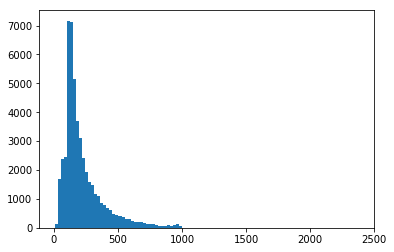

In [133]:
sequence_lens = sorted([len(s) for s in sequences])

# plots histogram
plt.hist(sequence_lens, bins=100)

In [138]:
embeddings_index = {}
glove_file = './glove.6B/glove.6B.50d.txt'

with open(glove_file, "r", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [139]:
EMBEDDING_DIM=50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [180]:
print(len(word_index))
print(len(embedding_matrix))

99476
99477


In [141]:
#print(list(word_index.items())[100])
# sentence word_index = 101
print(word_index['king'])
print(word_index['queen'])
print(embedding_matrix[682][:5])
print(embedding_matrix[1577][:5])
print(embedding_matrix[101][:5])
print(embedding_matrix[0][:5])

682
1577
[ 0.50450999  0.68607002 -0.59517002 -0.022801    0.60045999]
[ 0.37854001  1.8233     -1.26479995 -0.1043      0.35828999]
[ 0.19475     0.60993999 -0.66619998  0.01851     1.37290001]
[0. 0. 0. 0. 0.]


# Train, validation and test sets

In [158]:
# separate train, val and test. Take test as half val, half test.
X_train, y_train = data[:25000], labels[:25000]
X_val, y_val = data[25000:37500], labels[25000:37500]
X_test, y_test = data[37500:], labels[37500:]
X_test, y_test = data[25000:], labels[25000:]

In [159]:
print("# x_train: ", len(X_train))
print("# x_val: ", len(X_val))
print("# x_test: ", len(X_test))

# x_train:  25000
# x_val:  12500
# x_test:  25000


In [160]:
X_train_test, y_train_test = X_train[:50], y_train[:50]
X_val_test, y_val_test = X_val[:50], y_val[:50]
X_test_test, y_test_test = X_test[:10], y_test[:10]

# Models

### Vanilla RNN

In [181]:
def vanilla_rnn(num_words, state, lra, dropout, num_outputs=2, emb_dim=50, input_length=500):
    model = Sequential()
    model.add(Embedding(input_dim=num_words + 1, output_dim=emb_dim, input_length=input_length, trainable=False, weights=[embedding_matrix]))
    model.add(SimpleRNN(units=state, input_shape=(num_words,1), return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(num_outputs, activation='sigmoid'))
    
    rmsprop = optimizers.RMSprop(lr = lra)
    model.compile(loss = 'binary_crossentropy', optimizer = rmsprop, metrics = ['accuracy'])
    
    return model

### LSTM

In [182]:
def lstm_rnn(num_words, state, lra, dropout, num_outputs=2, emb_dim=50, input_length=500):
    model = Sequential()
    model.add(Embedding(input_dim=num_words + 1, output_dim=emb_dim, input_length=input_length, trainable=False, weights=[embedding_matrix]))
    model.add(LSTM(state))
    model.add(Dropout(dropout))
    model.add(Dense(num_outputs, activation='sigmoid'))
    
    rmsprop = optimizers.RMSprop(lr = lra)
    model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
    
    return model

# Setup Models

In [187]:
def runModel(state, lr, batch, dropout, model, epoch=5, num_outputs=2, emb_dim=100, input_length=2380):
        
    num_words = len(word_index)
    if model == "lstm": 
        model = lstm_rnn(num_words, state, lr, dropout)
    elif model == "vanilla":
        model = vanilla_rnn(num_words, state, lr, dropout)
        
    #model.summary()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch, batch_size=batch, verbose=1)

    testscore = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', testscore[0])
    print('Test accuracy:', testscore[1])
    
    return [history.history, testscore]

In [193]:
def hypruns(state, comb, repeats, model):
    history = []
    testscore = []

    for i in range(repeats):
        l, b, d = comb
        print("state %s, lr %s, batch %s, dropout %s." %(state, l, b, d))
        res = runModel(state, l, b, d, model)
        
        if res:
            history.append(res[0])
            testscore.append(res[1])
    
    # take avg of testscore
    testscore = list(np.mean(np.array(testscore), axis=0))
    hyps = [state] + comb
    
    return [history, testscore, hyps]

In [191]:
def tunehyps(states, comb, repeats, model):
    res = []
    hist = []
    for state in states:
        for comb in combs:
            history, testscore, hyps = hypruns(state, comb, repeats, model)
            res.append(testscore + hyps)
            hist.append(history)
                
        # save testscore to file
        with open('./experiments/'+model+'/testscore_'+'state_'+str(state), 'w', encoding="utf-8") as fout:
            pprint(res, fout)

        # save history to file
        with open('./experiments/'+model+'/history_'+'state_'+str(state), 'w', encoding="utf-8") as fout:
            pprint(hist, fout)

In [195]:
states = [20, 50, 100, 200, 500]
lrs = [0.1, 0.01, 0.001]
batches = [100, 200, 500]
dropouts = [0.1, 0.2, 0.5]
#epochs = [5, 10, 15]
repeats = 1
model = ["lstm", "vanilla"]
model = model[0]

numComb = 1
combs = []
np.random.seed(42)
for i in range(numComb):
    combs.append([np.random.choice(lrs), np.random.choice(batches), np.random.choice(dropouts)])

print(combs)

tunehyps(states, combs, repeats, model)

[[0.001, 100, 0.5]]
state 20, lr 0.001, batch 100, dropout 0.5.
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 99s 4ms/step - loss: 0.6939 - acc: 0.4978 - val_loss: 0.6923 - val_acc: 0.5070
Epoch 2/5
25000/25000 [==============================] - 80s 3ms/step - loss: 0.6917 - acc: 0.5076 - val_loss: 0.6899 - val_acc: 0.5127
Epoch 3/5
25000/25000 [==============================] - 79s 3ms/step - loss: 0.6878 - acc: 0.5147 - val_loss: 0.6845 - val_acc: 0.5243
Epoch 4/5
25000/25000 [==============================] - 80s 3ms/step - loss: 0.6556 - acc: 0.6240 - val_loss: 0.6277 - val_acc: 0.6736
Epoch 5/5
25000/25000 [==============================] - 79s 3ms/step - loss: 0.6317 - acc: 0.6764 - val_loss: 0.7026 - val_acc: 0.5492
Test loss: 0.7025632075500489
Test accuracy: 0.5492
state 50, lr 0.001, batch 100, dropout 0.5.
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 209

KeyboardInterrupt: 